
Restart 0
Step | Train MSE | Train Acc | Penalty | Test10 Acc | Test100 Acc
    0 | 2.1090 | 2.1090 | 0.0004 | 2.0497 | 2.1011
  100 | 1.0038 | 1.0038 | 0.0090 | 2.1028 | 8.6507
  200 | 1.1091 | 1.1091 | 0.0012 | 1.6247 | 3.5789
  300 | 1.1152 | 1.1152 | 0.0002 | 1.4951 | 3.1000
  400 | 1.1327 | 1.1327 | 0.0001 | 1.4743 | 3.0710
  500 | 1.1393 | 1.1393 | 0.0000 | 1.4570 | 2.9343
  600 | 1.1425 | 1.1425 | 0.0000 | 1.4528 | 2.8802
  700 | 1.1432 | 1.1432 | 0.0000 | 1.4491 | 2.8474
  800 | 1.1441 | 1.1441 | 0.0000 | 1.4467 | 2.8236
  900 | 1.1436 | 1.1436 | 0.0000 | 1.4441 | 2.8064
 1000 | 1.1422 | 1.1422 | 0.0000 | 1.4415 | 2.7953
 1100 | 1.1393 | 1.1393 | 0.0000 | 1.4402 | 2.7975
 1200 | 1.1365 | 1.1365 | 0.0000 | 1.4387 | 2.8002
 1300 | 1.1325 | 1.1325 | 0.0000 | 1.4394 | 2.8223
 1400 | 1.1310 | 1.1310 | 0.0000 | 1.4352 | 2.8064
 1500 | 1.1285 | 1.1285 | 0.0000 | 1.4341 | 2.8106
 1600 | 1.1270 | 1.1270 | 0.0000 | 1.4323 | 2.8124
 1700 | 1.1230 | 1.1230 | 0.0000 | 1.4313 | 2.8187
 1800

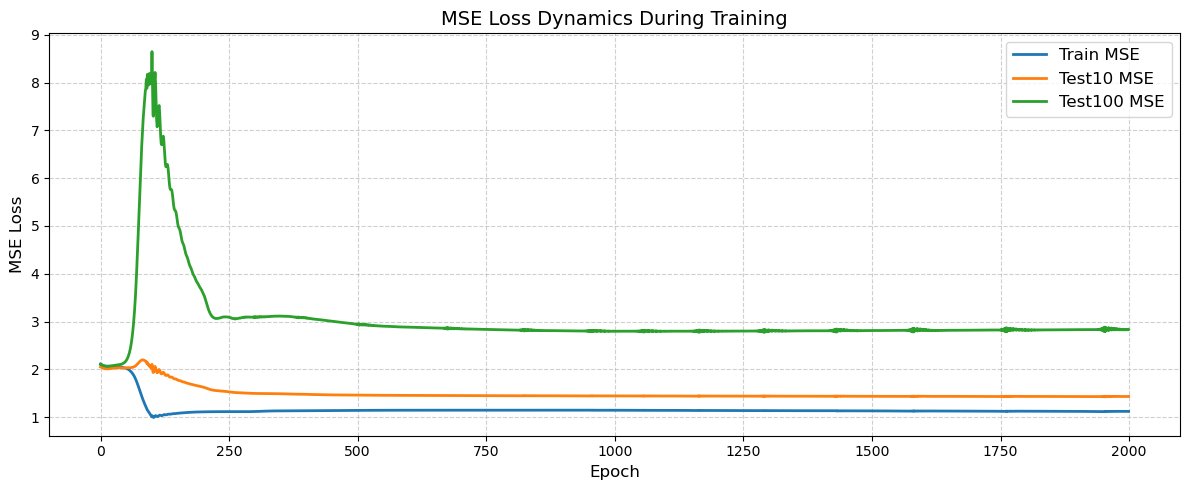

[1.66776276 1.66726375 1.66652942 ... 0.65811014 0.65963751 0.65825301]


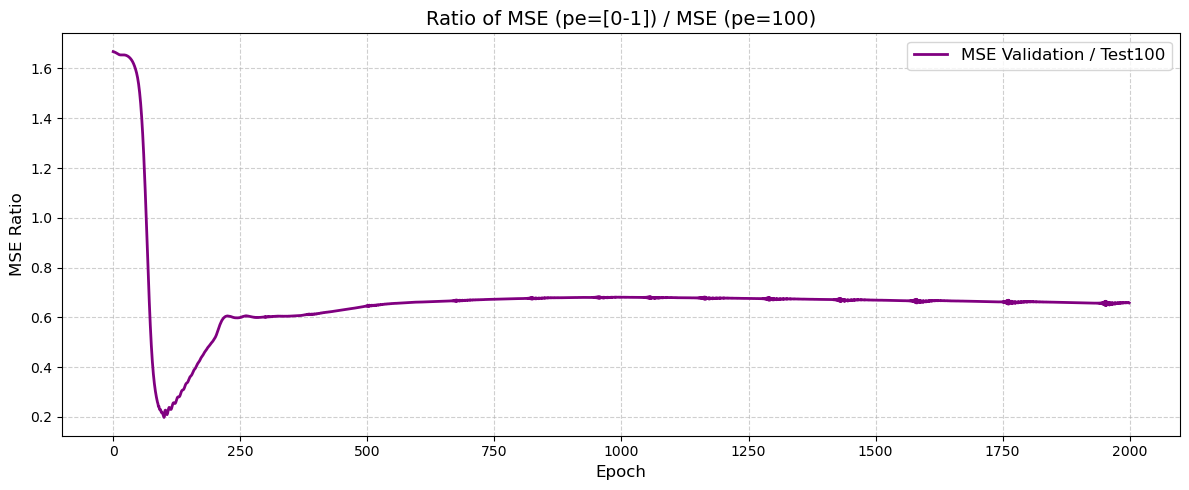

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")  # Принудительно CPU

# Генерация данных
def generate_dataset(pe, n_samples):
    x_inv = np.random.randn(n_samples, 2, )
    Y = x_inv.sum(axis=1, keepdims=True) + 0.1 * np.random.randn(n_samples, 1)
    x_env = np.column_stack([Y, Y]) + np.sqrt(pe) * np.random.randn(n_samples, 2)
    X = np.hstack([x_inv, x_env])
    return (
        torch.tensor(X, dtype=torch.float32).to(device),
        torch.tensor(Y, dtype=torch.float32).to(device)
    )

# Модель
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Функции потерь
def mean_mse(logits, y):
    return nn.MSELoss()(logits.squeeze(), y.squeeze())

def mean_accuracy(logits, y):
    return torch.nn.functional.mse_loss(logits.squeeze(), y.squeeze())

def penalty(logits, y):
    scale = torch.tensor(1.).to(device).requires_grad_()
    loss = mean_mse(logits * scale, y)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return (grad ** 2).sum()

# IRM обучение с логированием и графиками
def train_irm_model(n_restarts=5, n_steps=500, verbose=True):
    input_dim = 4
    hidden_dim = 16
    output_dim = 1
    lr = 1e-3
    penalty_anneal_iters = 100
    penalty_weight = 100000.0
    l2_regularizer_weight = 1e-4

    best_results = []

    # Для отслеживания метрик
    all_train_losses = []
    all_test10_losses = []
    all_test100_losses = []
    all_ratio_losses = []

    for restart in range(n_restarts):
        model = SimpleMLP(input_dim, hidden_dim, output_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        envs = {
            'train0': generate_dataset(0.1, 1000),
            'train1': generate_dataset(0.3, 1000),
            'train2': generate_dataset(0.5, 1000),
            'train3': generate_dataset(0.7, 1000),
            'train4': generate_dataset(0.9, 1000),
            'val1': generate_dataset(0.2, 1000),
            'val2': generate_dataset(0.4, 1000),
            'val3': generate_dataset(0.6, 1000),
            'test10': generate_dataset(10, 1000),
            'test100': generate_dataset(100, 1000)
        }

        best_min_acc = 0.0
        best_step = 0
        best_model = None
        last_model = None

        if verbose:
            print(f"\nRestart {restart}")
            print("Step | Train MSE | Train Acc | Penalty | Test10 Acc | Test100 Acc")

        train_losses = []
        test10_losses = []
        test100_losses = []
        ratio_losses = []

        for step in range(n_steps):
            total_loss = 0
            train_mse = 0
            train_acc = 0
            penalties = []

            for name, (X, Y) in envs.items():
                logits = model(X)
                if 'train' in name:
                    loss = mean_mse(logits, Y)
                    grad_penalty = penalty(logits, Y)
                    penalties.append(grad_penalty)
                    train_mse += loss.item()
                    train_acc += mean_accuracy(logits, Y)
                    total_loss += loss

            train_mse /= len([n for n in envs if 'train' in n])
            train_acc /= len([n for n in envs if 'train' in n])
            penalty_term = torch.stack(penalties).mean()

            annealed_penalty = penalty_weight if step >= penalty_anneal_iters else 100.0
            loss = total_loss + l2_regularizer_weight * sum(p.pow(2).sum() for p in model.parameters())
            loss += annealed_penalty * penalty_term

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Тест
            with torch.no_grad():
                test10_logits = model(envs['test10'][0])
                test10_acc = mean_accuracy(test10_logits, envs['test10'][1])

                test100_logits = model(envs['test100'][0])
                test100_acc = mean_accuracy(test100_logits, envs['test100'][1])

                # Отношение MSE на pe=[0 до 1] к pe=100
                val_avg = 0
                for name in envs:
                    if 'train' in name:
                        val_avg += mean_accuracy(model(envs[name][0]), envs[name][1])
                        
                val_avg /= 3
                
                ratio = val_avg / test100_acc
                #print(val_avg, test100_acc)

            train_losses.append(train_mse)
            test10_losses.append(test10_acc.item())
            test100_losses.append(test100_acc.item())
            ratio_losses.append(ratio.item())

            min_acc = min(test10_acc, test100_acc)
            if min_acc > best_min_acc:
                best_min_acc = min_acc
                best_step = step
                best_model = model

            last_model = model
            if verbose and step % 100 == 0:
                print(f"{step:5d} | {train_mse:.4f} | {train_acc:.4f} | {penalty_term.item():.4f} | {test10_acc:.4f} | {test100_acc:.4f}")

        all_train_losses.append(train_losses)
        all_test10_losses.append(test10_losses)
        all_test100_losses.append(test100_losses)
        all_ratio_losses.append(ratio_losses)

        if best_model is not None:
            model = best_model
        else:
            model = last_model
            print("⚠️ Best model not found, using last model")

        with torch.no_grad():
            test10_acc = mean_accuracy(model(envs['test10'][0]), envs['test10'][1])
            test100_acc = mean_accuracy(model(envs['test100'][0]), envs['test100'][1])
            best_results.append((test10_acc, test100_acc))
            print(f"Restart {restart} best: Test10={test10_acc:.4f}, Test100={test100_acc:.4f}")

    avg_test10 = np.mean([r[0] for r in best_results])
    avg_test100 = np.mean([r[1] for r in best_results])
    std_test10 = np.std([r[0] for r in best_results])
    std_test100 = np.std([r[1] for r in best_results])

    print("\nIRM Results:")
    print(f"Test10 Accuracy: {avg_test10:.4f} ± {std_test10:.4f}")
    print(f"Test100 Accuracy: {avg_test100:.4f} ± {std_test100:.4f}")

    # Среднее по перезапускам
    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_test10_losses = np.mean(all_test10_losses, axis=0)
    avg_test100_losses = np.mean(all_test100_losses, axis=0)
    avg_ratio_losses = np.mean(all_ratio_losses, axis=0)

    # График MSE
    plt.figure(figsize=(12, 5))
    plt.plot(avg_train_losses, label="Train MSE", linewidth=2)
    plt.plot(avg_test10_losses, label="Test10 MSE", linewidth=2)
    plt.plot(avg_test100_losses, label="Test100 MSE", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("MSE Loss", fontsize=12)
    plt.title("MSE Loss Dynamics During Training", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # График отношения MSE
    plt.figure(figsize=(12, 5))
    print(avg_ratio_losses)
    plt.plot(avg_ratio_losses, label="MSE Validation / Test100", color='purple', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("MSE Ratio", fontsize=12)
    plt.title("Ratio of MSE (pe=[0-1]) / MSE (pe=100)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model

if __name__ == "__main__":
    model = train_irm_model(n_restarts=1, n_steps=2000)
    print(model)